# Notebook 3: Model Building and Training

- **Project:** ML-Based Blockchain Trading Strategy
- **Step:** 3 (Modeling)
- **Description:** This notebook splits the data chronologically, trains machine learning models to predict the next hour's return, and evaluates their performance using statistical and financial metrics.

## 3.1 Setup and Data Loading

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import joblib
import os

project_path = "/content/drive/MyDrive/Crypto_ML_Project"
processed_path = f"{project_path}/BTC_1H_processed.csv"

# 3. Load Data
df = pd.read_csv(processed_path, parse_dates=['timestamp'])
print(f"Loaded {len(df)} rows.")

Mounted at /content/drive
Loaded 671 rows.


## 3.2 Feature Selection and Train-Test Split
We must use a Chronological Split. In trading, you can never use "future" data to predict the "past." We use the first 80% of history to train and the most recent 20% to test.

In [ ]:
# Define our Features (X) and Target (y)
# We exclude raw price and timestamp from the features
features = [
    'rsi', 'stoch_osc', 'ema_dist', 'ema_cross',
    'bb_width', 'vol_change', 'return_1h',
    'return_4h', 'return_24h', 'hour', 'day_of_week'
]
target = 'target'

X = df[features]
y = df[target]

# Chronological Split (80% Train / 20% Test)
split = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f"Training Period: {df['timestamp'].iloc[0]} to {df['timestamp'].iloc[split-1]}")
print(f"Testing Period: {df['timestamp'].iloc[split]} to {df['timestamp'].iloc[-1]}")

Training Period: 2025-12-25 18:00:00 to 2026-01-17 01:00:00
Testing Period: 2026-01-17 02:00:00 to 2026-01-22 16:00:00


## 3.3 Model 1: XGBoost (Gradient Boosting)
XGBoost is the "Jansen Favorite." It handles non-linear relationships and is robust to outliers.

In [ ]:
# Initialize XGBoost with parameters to prevent overfitting
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50 # Stops training if test error stops improving
)

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

## 3.4 Model 2: Random Forest (Baseline)
Random Forest is a simpler ensemble method. It serves as a good benchmark to see if the complexity of XGBoost is necessary.

In [ ]:
# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

Training Random Forest...


## 3.5 Evaluation: Directional Accuracy
In trading, the exact price prediction matters less than the Direction (Up or Down). We calculate how often the model correctly predicts the sign of the next candle.

In [ ]:
def evaluate_direction(y_true, y_pred):
    # Convert returns to binary direction (1 for Up, -1 for Down)
    true_dir = np.where(y_true > 0, 1, -1)
    pred_dir = np.where(y_pred > 0, 1, -1)
    return accuracy_score(true_dir, pred_dir)

acc_xgb = evaluate_direction(y_test, y_pred_xgb)
acc_rf = evaluate_direction(y_test, y_pred_rf)

print(f"--- Model Accuracy (Sign Prediction) ---")
print(f"XGBoost Accuracy: {acc_xgb:.2%}")
print(f"Random Forest Accuracy: {acc_rf:.2%}")

--- Model Accuracy (Sign Prediction) ---
XGBoost Accuracy: 49.63%
Random Forest Accuracy: 50.37%


## 3.6 Feature Importance
Which "Alpha Factors" are actually driving the model's decisions?

<Figure size 1000x600 with 0 Axes>

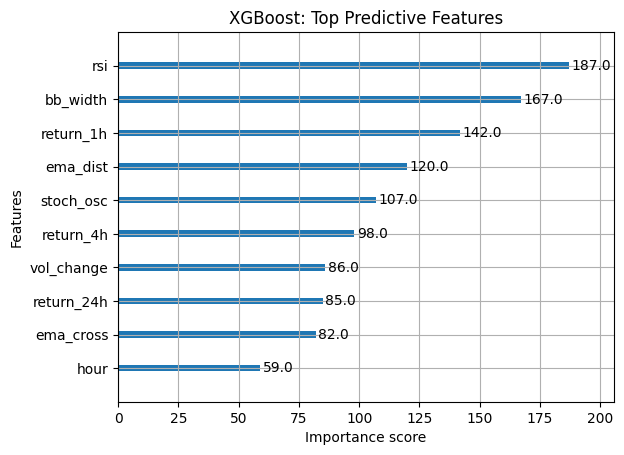

In [ ]:
# Plotting XGBoost Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("XGBoost: Top Predictive Features")
plt.show()

## 3.7 Saving Models and Predictions
We save the models and the predictions for use in the Backtesting and Flask notebooks.

In [ ]:
# 1. Save Models
xgb_model.save_model(f"{project_path}/xgb_model.json")
joblib.dump(rf_model, f"{project_path}/rf_model.pkl")

# 2. Save Test Predictions for Notebook 4 (Backtesting)
# We create a dataframe containing the actual returns and our model predictions
results_df = pd.DataFrame({
    'timestamp': df['timestamp'].iloc[split:],
    'actual_return': y_test,
    'xgb_pred': y_pred_xgb,
    'rf_pred': y_pred_rf,
    'close': df['close'].iloc[split:]
})

results_df.to_csv(f"{project_path}/test_predictions.csv", index=False)

print(f"Models and Predictions saved to Google Drive.")

Models and Predictions saved to Google Drive.


1. **Directional Accuracy:** For crypto hourly data, an accuracy between 51.5% and 54% is usually enough to build a profitable strategy after fees. If it's 50%, the model is essentially guessing.
2. **XGBoost vs RF:** Typically, XGBoost will have slightly lower accuracy but better "Mean Squared Error" on large moves.
3. Features: Look at the importance plot. If hour is at the top, it means the model found a "time-of-day" bias in the crypto markets.